In this notebook I'll explore the methods for dimensionality reduction on the transformed data, which has quite a few colinearity. 

### Load and transform

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

In [7]:
import nzcompetition

In [8]:
df, _, _ = nzcompetition.get_raw_data(target='odor')

In [9]:
df = nzcompetition.drop_dup(df)

transformer = nzcompetition.Transformer()
X = transformer.fit_transform(df)

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:228: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


In [10]:
X.shape

(122, 42)

In [7]:
transformer.df_columns_

array(['{"Orion TLL Lipase"}', '{"Powder Lipase for AP toploaders"}',
       '{"Powder lipase for toploaders"}', '{"Sirius Lipase"}',
       '{"Tiger Lili"}', '{}', 'pune_auc',
       'OCTET Stab1 Rel X=40 Cycle1/Cycle2',
       'OCTET Stab2 Rel X=290 Cycle1/Cycle2', 'response', 'br_2', 'br_4',
       'br_3', 'br_1', 'x_auc', 'A280/A260', 'A280', 'volume_bin',
       'AST Concentration mg/ml', 'A280 Concentration mg/ml',
       'AMSA_per_trial_odor_rp_Model_X_6',
       'AMSA_per_trial_wash_rp_Model_X_6',
       'AMSA_per_trial_wash_rp_Persil_Universal_15',
       'AMSA_across_trial_rp_odor_Model_X_6',
       'AMSA_across_trial_rp_wash_Model_X_6',
       'AMSA_across_trial_rp_wash_Persil_Universal_15',
       'TOM Wash AT Model X', 'TOM Odor AT Model X',
       'GLAD_lipex_units Model-Y-like', 'GLAD_slope Model-Y-like',
       'pNP Lipex Units Model-X-like', 'pNP Mean Slope Model-X-like',
       'BBS', 'IWS Degradation Factor Rinso 10.2',
       'IWS Initial Activity Rinso 10.2',
     

Now we've get the input for dimensionality reduction.

### PCA

In [11]:
from sklearn.decomposition import PCA

In [27]:
# first use all default settings
pca = PCA()

In [28]:
X_pca = pca.fit_transform(X)

In [29]:
X_pca.shape

(122, 42)

Text(0.5, 1.0, 'Cumulative explained variance')

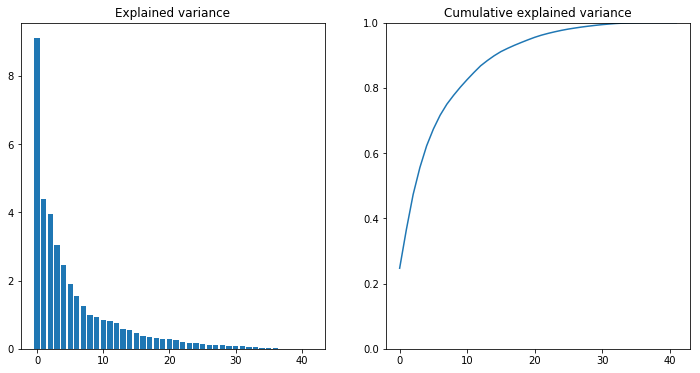

In [30]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
ax1.bar(height=pca.explained_variance_, x=np.arange(len(pca.explained_variance_)))
ax1.set_title('Explained variance')

ax2 = fig.add_subplot(122)
ax2.plot(
    np.arange(len(pca.explained_variance_)), 
    np.cumsum(pca.explained_variance_ratio_), 
)
ax2.set_ylim(0, 1)
ax2.set_title('Cumulative explained variance')

As we can see the top 10 PCs can explain ~80% of the total variance, and top 20 PCs near 95%. Here I'll choose 0.95 as the `n_components`, which means over 95% variance can be explained.

Also note that the PCA should be fit to training data only. This way the test data follows same transformation.

In [12]:
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

In [33]:
pca.n_components_

21

Text(0.5, 1.0, 'Cumulative explained variance')

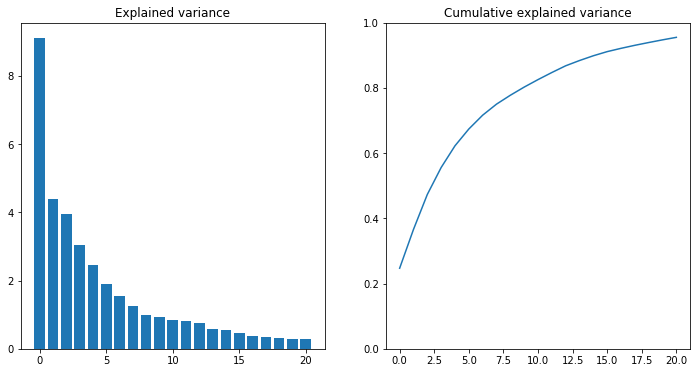

In [38]:
fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121)
ax1.bar(height=pca.explained_variance_, x=np.arange(len(pca.explained_variance_)))
ax1.set_title('Explained variance')

ax2 = fig.add_subplot(122)
ax2.plot(
    np.arange(len(pca.explained_variance_)), 
    np.cumsum(pca.explained_variance_ratio_), 
)
ax2.set_ylim(0, 1)
ax2.set_title('Cumulative explained variance')

Let's see what's in the top several PCs.

In [42]:
pca.components_.shape

(21, 42)

In [56]:
pc1_components = pca.components_[0]

<BarContainer object of 42 artists>

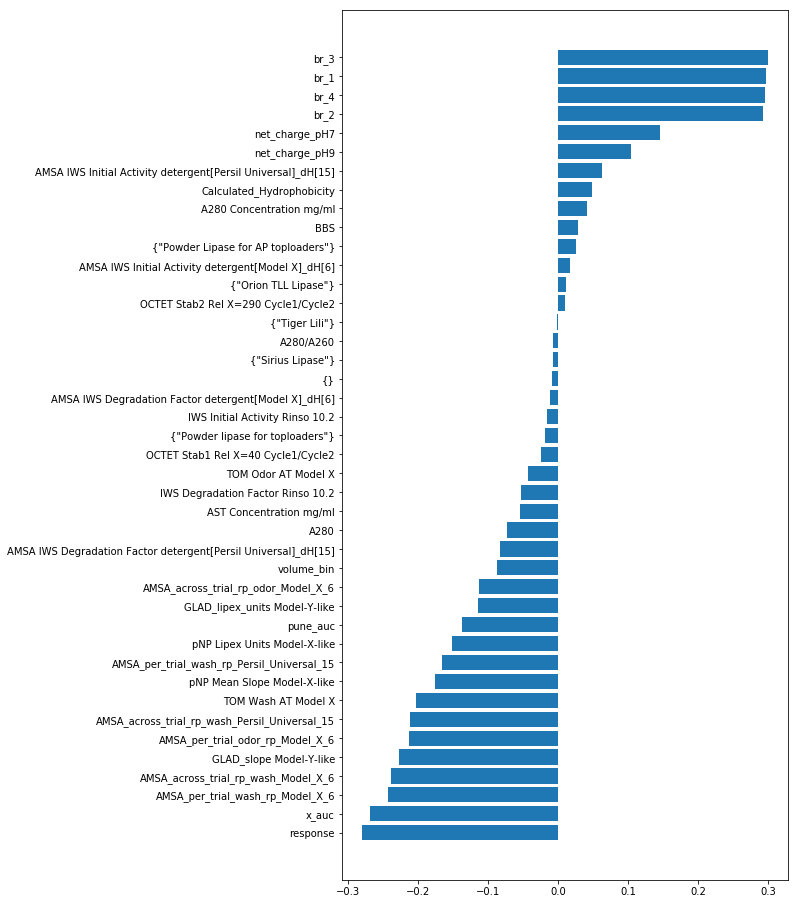

In [57]:
fig, ax = plt.subplots(1,1, figsize=(8, 16))

ax.barh(
    y=range(len(pc1_components)), 
    width=pc1_components[pc1_components.argsort()], 
    tick_label=transformer.df_columns_[pc1_components.argsort()]
)


In [58]:
pc2_components = pca.components_[1]

<BarContainer object of 42 artists>

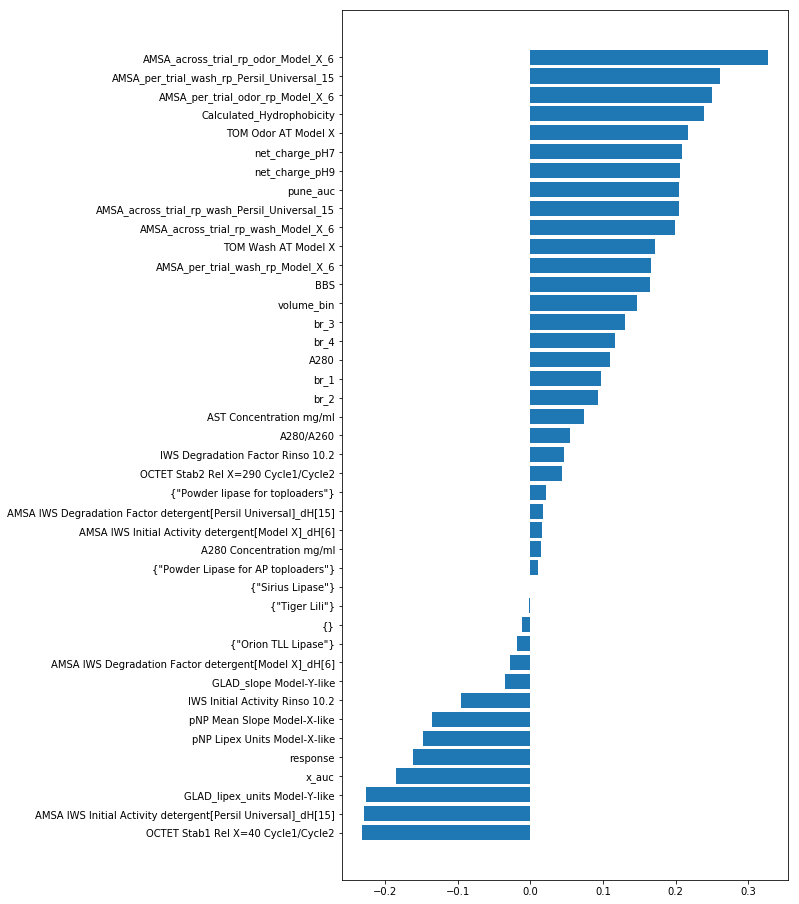

In [59]:
fig, ax = plt.subplots(1,1, figsize=(8, 16))

ax.barh(
    y=range(len(pc2_components)), 
    width=pc2_components[pc2_components.argsort()], 
    tick_label=transformer.df_columns_[pc2_components.argsort()]
)


### Save the PCA

Since the PCA is only fit by training data, we can save it by module `sklearn.externals.joblib` if necessary. For now we can
just save the `n_component` configuration to the `config.ini` if necessary.

### ICA

In [13]:
from sklearn.decomposition import FastICA

In [20]:
ica = FastICA(n_components=25)

In [21]:
X_ica = ica.fit_transform(X)

Note: In later modeling I found that PCA is better than ICA in reducing dimension of this dataset. Using PCA on this dataset, 26 components can preserve 0.98 variances.